In [1]:
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
from dft import DFT, DFTI, dft_python_model, complex_abs, nrsqrt, postproc

In [3]:
from data import open_sample

## DFT float implementation test

In [4]:
N = 16  # Window points
M = 256  # Number of signal chunks
x = np.float32(np.random.randint(-2047, 2048, size=(M, N), dtype=np.int32))

fft_np_res = np.fft.fft(x)

dft_res = np.zeros_like(fft_np_res)
dft = DFT(N)
for i in range(M):
    dft_res[i] = dft.calc(x[i])

np.allclose(fft_np_res, dft_res)

True

## DFT integer implementation test

In [5]:
N = 16  # Window points
M = 256  # Number of signal chunks
np.random.seed(42)
x = np.float32(np.random.randint(-2047, 2048, size=(M, N), dtype=np.int32))

fft_np_res = np.fft.fft(x)

dfti_res = np.zeros_like(fft_np_res)
dfti = DFTI(N)
for i in range(M):
    dfti_res[i] = dfti.calc(x[i])

err_percent = 100*np.abs(np.abs(fft_np_res) - np.abs(dfti_res))/np.abs(fft_np_res)
print("Mean error = %f%%, Median error = %f%%" % (np.mean(err_percent), np.median(err_percent)))

Mean error = 0.074080%, Median error = 0.023118%


## Complex abs() implementation test

In [6]:
N = 64
np.random.seed(42)
x_re = (np.random.randint(-32768, 32767, size=N, dtype=np.int32))
x_im = (np.random.randint(-32768, 32767, size=N, dtype=np.int32))
x = x_re + 1j * x_im
res_ideal = np.uint16(np.sqrt(x.real**2 + x.imag**2))

complex_abs_res = np.zeros(N, dtype=np.uint16)
for i in range(N):
    complex_abs_res[i] = complex_abs(x[i])

print(np.allclose(res_ideal, complex_abs_res))

True


## Non-restoring sqrt() implementation test

In [7]:
N = 8192
DATA_W = 32
a = np.random.randint(0, 2**DATA_W, size=N, dtype=np.uint32)

nrsqrt_res = np.zeros(N, dtype=np.uint16)
for i in range(8192):
    nrsqrt_res[i] = nrsqrt(a[i], DATA_W)

np_res = np.uint16(np.sqrt(a))

print(np.allclose(nrsqrt_res, np_res))

True


## Verilog DFT module demo

### Open data

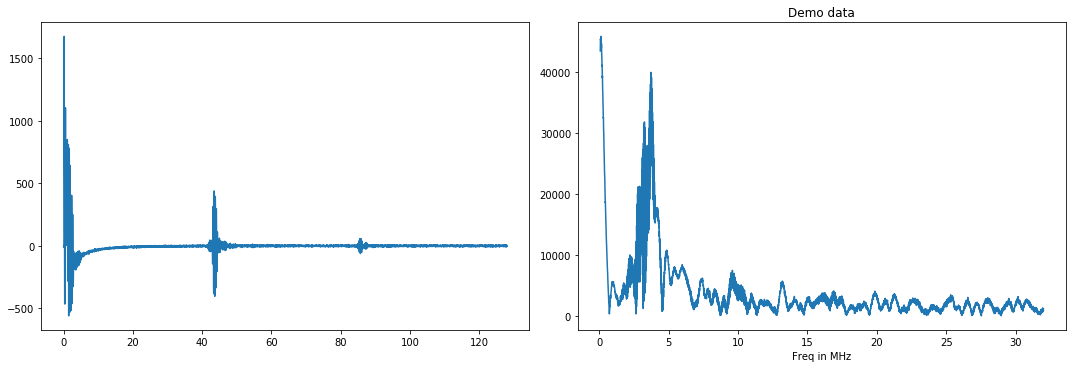

In [8]:
RES = open_sample()
n = len(RES)
tRaw = [x/64.0 for x in range(n)]
Nmax = int(n/2)
f = [x*64.0/n for x in range(n)]
FFT = np.fft.fft(RES)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(tRaw, RES)
plt.xlabel('Time in microseconds')

axes[1].plot(f[10:Nmax], np.abs(FFT)[10:Nmax])
plt.xlabel('Freq in MHz')

fig.tight_layout()
plt.title("Demo data")
plt.show()

###  NumPy envelope extraction

In [9]:
def env256_np(data):
    n = len(data)
    N = 256
    fDebut = 1
    widthFreqWindow = 3
    w = int(n/N)
    envSeg = []
    tSeg = [x*128.0/N for x in range(N)]

    for k in range(N):
        FFT = np.fft.fft(data[(k*w):(((k+1)*w))])
        envSeg.append(0.125*0.5*np.sum(np.abs(FFT[fDebut:fDebut+widthFreqWindow])))
    return envSeg

env256_np_seg = env256_np(RES)

### Python DFT module envelope extraction

In [10]:
def env256_dft_py(data):
    N = 256
    n = len(data)
    data_arr = np.array(data).reshape(N, -1)    
    envSeg = dft_python_model(data_arr)
    return list(envSeg)

env256_dft_py_seg = env256_dft_py(RES)

### Verilog DFT module envelope extraction

In [11]:
def open_verilog_demo_out(filename='../sim/tb/tb_demo_out.mem'):
    with open(filename) as mem_file:
        raw_lines = mem_file.readlines()
    data = [int(i, 16) for i in raw_lines if "//" not in i]
    return data
        
env256_dft_vlog_seg = open_verilog_demo_out()
# Check if Python behavioral model and verilog results are the same
np.allclose(env256_dft_py_seg, env256_dft_vlog_seg)

True

### Testing

In [12]:
RES_Scaled = 1.5*np.array(RES)
tRaw_scaled = np.array(tRaw) - 0.25
N=256
tSeg = [x*128.0/N for x in range(N)]

(-50, 700)

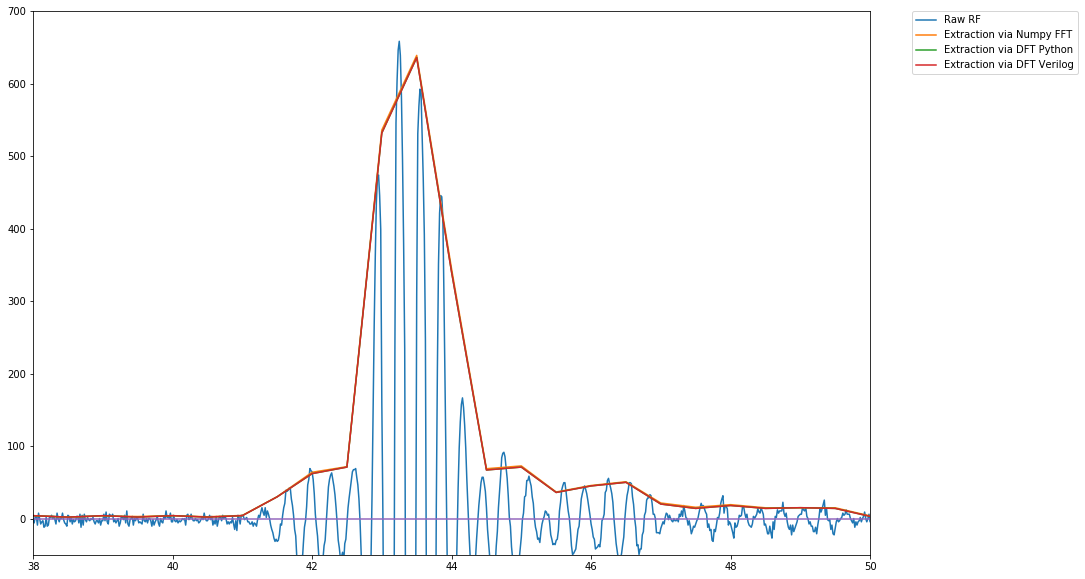

In [13]:
plt.figure(figsize=(15, 10))

plt.plot(tRaw_scaled, RES_Scaled, label='Raw RF')
plt.plot(tSeg, (env256_np_seg), label='Extraction via Numpy FFT')
plt.plot(tSeg, (env256_dft_py_seg), label='Extraction via DFT Python')
plt.plot(tSeg, (env256_dft_vlog_seg), label='Extraction via DFT Verilog')
plt.plot(tSeg, np.zeros(len(tSeg)))
plt.title("Enveloppe extraction")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("")
plt.xlim(38, 50)
plt.ylim(-50, 700)

Text(0.5, 1.0, '')

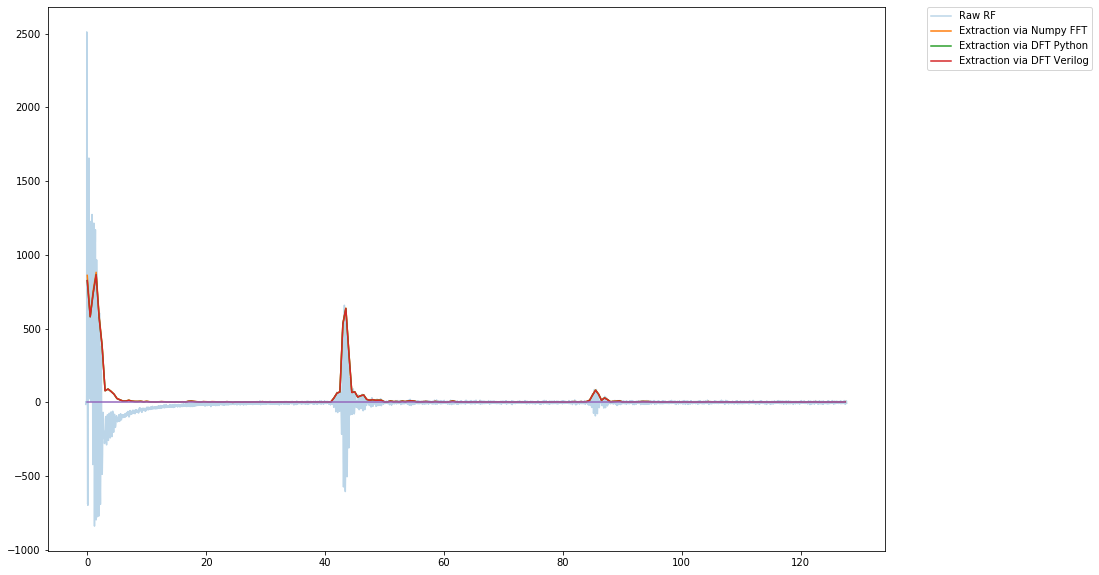

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(tRaw_scaled, RES_Scaled, label='Raw RF', alpha=0.3)
plt.plot(tSeg, (env256_np_seg), label='Extraction via Numpy FFT')
plt.plot(tSeg, (env256_dft_py_seg), label='Extraction via DFT Python')
plt.plot(tSeg, (env256_dft_vlog_seg), label='Extraction via DFT Verilog')
plt.title("Enveloppe extraction")
plt.plot(tSeg, np.zeros(len(tSeg)))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("")

(-10, 120)

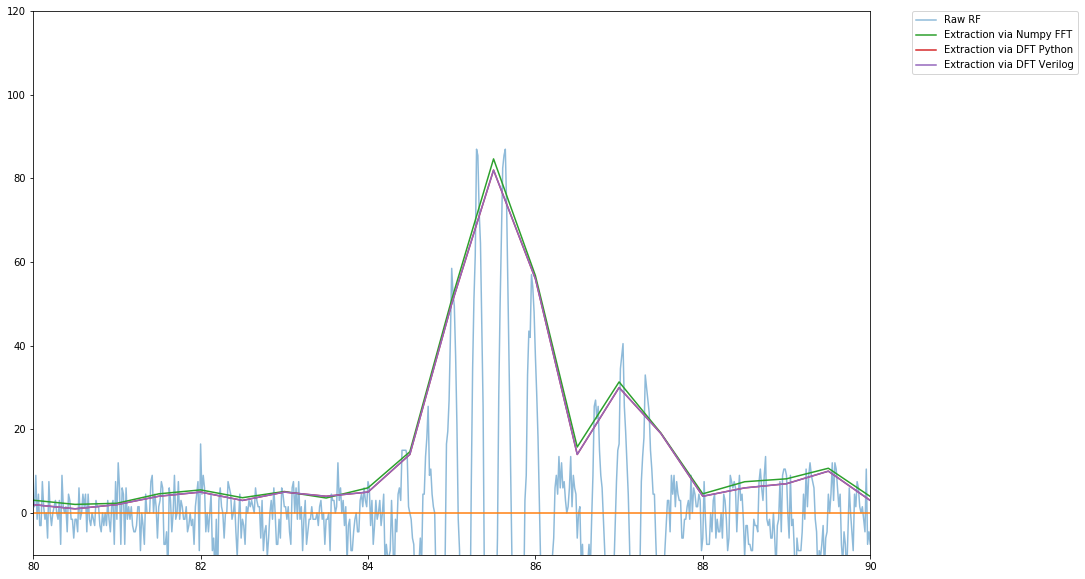

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(tRaw_scaled, RES_Scaled, label='Raw RF', alpha=0.5)
plt.plot(tSeg, np.zeros(len(tSeg)))
plt.plot(tSeg, (env256_np_seg), label='Extraction via Numpy FFT')
plt.plot(tSeg, (env256_dft_py_seg), label='Extraction via DFT Python')
plt.plot(tSeg, (env256_dft_vlog_seg), label='Extraction via DFT Verilog')
plt.title("Enveloppe extraction")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("")
plt.xlim(80, 90)
plt.ylim(-10, 2*60)

## File generation for testbenches

### tb_dft_core

In [16]:
N = 16  # Window points
M = 256  # Number of signal chunks
np.random.seed(42)
x = np.float32(np.random.randint(-2048, 2047, size=(M, N), dtype=np.int32))

fft_np_res = np.fft.fft(x)

dfti_res = np.zeros_like(fft_np_res)
dfti = DFTI(N)
for i in range(M):
    dfti_res[i] = dfti.calc(x[i])

with open('../sim/tb/tb_dft_core_in.mem', 'w') as mem_file:
    for val in np.int32(x.flatten()):
            mem_file.write('%s\n' % str(hex(val & 0xFFF))[2:])

with open('../sim/tb/tb_dft_core_out_re.mem', 'w') as mem_file:
    for val in np.int32(dfti_res.real[:, 1:4]).flatten():
            mem_file.write('%s\n' % str(hex(val & 0xFFFF))[2:])
            
with open('../sim/tb/tb_dft_core_out_im.mem', 'w') as mem_file:
    for val in np.int32(dfti_res.imag[:, 1:4]).flatten():
            mem_file.write('%s\n' % str(hex(val & 0xFFFF))[2:])

### tb_dft_sqrt

In [17]:
N = 256
np.random.seed(42)
x = (np.random.randint(0, 2**32, size=N, dtype=np.uint32))

sqrt_res = np.zeros(N, dtype=np.uint16)
for i in range(N):
    sqrt_res[i] = nrsqrt(x[i])

with open('../sim/tb/tb_dft_sqrt_in.mem', 'w') as mem_file:
    for val in x:
        mem_file.write('%s\n' % str(hex(val & 0xFFFFFFFF))[2:])

with open('../sim/tb/tb_dft_sqrt_out.mem', 'w') as mem_file:
    for val in sqrt_res:
        mem_file.write('%s\n' % str(hex(val & 0xFFFF))[2:])

### tb_dft_complex_abs

In [18]:
N = 256*3
np.random.seed(42)
x_re = (np.random.randint(-32768, 32767, size=N, dtype=np.int32))
x_im = (np.random.randint(-32768, 32767, size=N, dtype=np.int32))
x = x_re + 1j * x_im

complex_abs_res = np.zeros(N, dtype=np.uint16)
for i in range(N):
    complex_abs_res[i] = complex_abs(x[i])

with open('../sim/tb/tb_dft_complex_abs_in_re.mem', 'w') as mem_file:
    for val in np.int16(x.real):
        mem_file.write('%s\n' % str(hex(val & 0xFFFF))[2:])

with open('../sim/tb/tb_dft_complex_abs_in_im.mem', 'w') as mem_file:
    for val in np.int16(x.imag):
        mem_file.write('%s\n' % str(hex(val & 0xFFFF))[2:])

with open('../sim/tb/tb_dft_complex_abs_out.mem', 'w') as mem_file:
    for val in complex_abs_res:
        mem_file.write('%s\n' % str(hex(val & 0xFFFF))[2:])

### tb_dft_postproc

In [19]:
M = 256
N = 16
np.random.seed(42)
x_re = (np.random.randint(-32768, 32767, size=(M, N), dtype=np.int32))
x_im = (np.random.randint(-32768, 32767, size=(M, N), dtype=np.int32))
x = x_re + 1j * x_im

postproc_res = postproc(x)

with open('../sim/tb/tb_dft_postproc_in_re.mem', 'w') as mem_file:
    for val in np.int16(x[:, 1:4].real.flatten()):
        mem_file.write('%s\n' % str(hex(val & 0xFFFF))[2:])

with open('../sim/tb/tb_dft_postproc_in_im.mem', 'w') as mem_file:
    for val in np.int16(x[:, 1:4].imag.flatten()):
        mem_file.write('%s\n' % str(hex(val & 0xFFFF))[2:])

with open('../sim/tb/tb_dft_postproc_out.mem', 'w') as mem_file:
    for val in postproc_res:
        mem_file.write('%s\n' % str(hex(val & 0x7FFF))[2:])

### tb_dft

In [20]:
N = 32  # Window points
M = 256  # Number of signal chunks
np.random.seed(42)
x = np.float32(np.random.randint(-2048, 2047, size=(M, N), dtype=np.int32))
res = dft_python_model(x)

with open('../sim/tb/tb_dft_in.mem', 'w') as mem_file:
    for val in np.int32(x.flatten()):
            mem_file.write('%s\n' % str(hex(val & 0xFFF))[2:])

with open('../sim/tb/tb_dft_out.mem', 'w') as mem_file:
    for val in res:
            mem_file.write('%s\n' % str(hex(val & 0x7FFF))[2:])

### tb_demo

In [21]:
with open('../sim/tb/tb_demo_in.mem', 'w') as mem_file:
    for val in RES:
            mem_file.write('%s\n' % str(hex(val & 0xFFF))[2:])

## Twiddle ROM files generator for RTL

In [22]:
def gen_mem_file(n, freq_parts, prefix="./"):
    dfti = DFTI(n)
    twiddles_float = [np.exp(2j * np.pi * i / n) for i in freq_parts]
    twiddles = np.zeros(len(freq_parts), dtype=DFTI.complex_int32)
    for i, tw in enumerate(twiddles_float):
        twiddles[i] = dfti.twiddle_conv(tw)
    with open(prefix + '/' + 'dft_twiddle_re_%d.mem' % n, 'w') as mem_file:
        for tw in twiddles:
            mem_file.write('%s\n' % str(hex((tw['re']) & 0xFFFF))[2:])
    with open(prefix + '/' + 'dft_twiddle_im_%d.mem' % n, 'w') as mem_file:
        for tw in twiddles:
            mem_file.write('%s\n' % str(hex((tw['im']) & 0xFFFF))[2:])

for i in [8, 16, 32]:
    gen_mem_file(i, [1,2,3], "../rtl/mem_files")